# **ML Assignment 9**

By 23520011 - Sharaneshwar Punjal

Download the following dataset - https://www.kaggle.com/datasets/erdemtaha/cancer-data/data 

1. Drop Id and Diagnosis columns 
2. Cluster the data using K means clustering:
    - Determine optimal number of clusters (between 2-10) using
        - Elbow method with Inertia and
        - Silhouette Analysis 
    - Use the diagnosis column to calculate homogeneity score and evaluate quality of clustering 
3. Cluster the data using DB scan clustering.
    - Determine appropriate values of eps and  min_samples parameters 
    - Use the diagnosis column to calculate homogeneity score and evaluate quality of clustering

In [2]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from kneed import KneeLocator

In [3]:
# Load dataset
df = pd.read_csv("Cancer_Data.csv")
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


- The dataset has 569 entries and 33 columns.
- Columns include patient `id`, `diagnosis`, and various numeric features.
- We'll drop `id` and store `diagnosis` for evaluation.

In [4]:
# Drop id, unnamed column and diagnosis (store it separately)
X = df.drop(columns=['id', 'Unnamed: 32', 'diagnosis'])
y = df['diagnosis']

## K Means Clustering

Optimal number of clusters (Elbow): 5


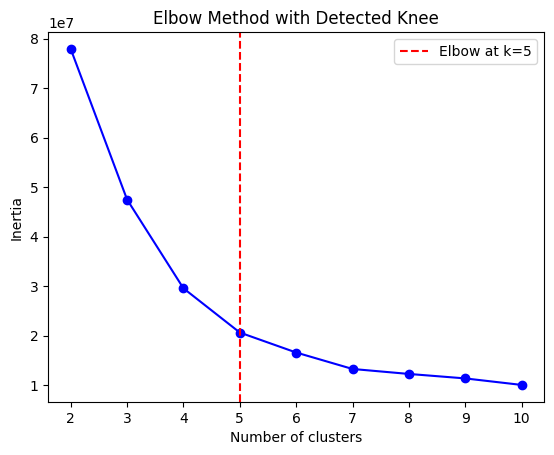

In [5]:
inertias = []
Range = range(2, 11)

for i in Range:
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Find the elbow point
knee = KneeLocator(Range, inertias, curve='convex', direction='decreasing')

print(f"Optimal number of clusters (Elbow): {knee.knee}")

# Plot
plt.plot(Range, inertias, 'bo-')
plt.axvline(knee.knee, color='red', linestyle='--', label=f'Elbow at k={knee.knee}')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method with Detected Knee')
plt.legend()
plt.show()

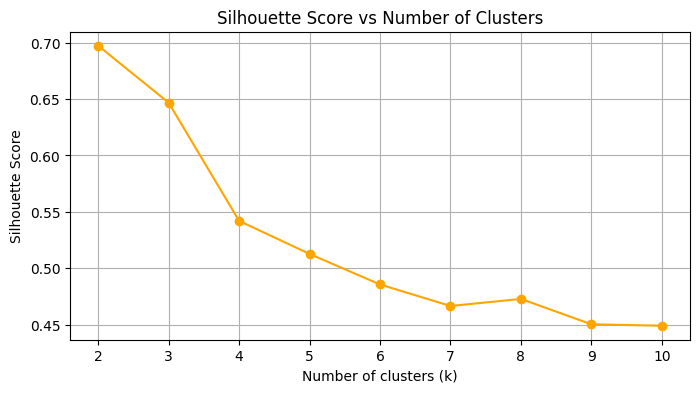

In [6]:
silhouette_scores = []

for i in Range:
    kmeans = KMeans(n_clusters=i, random_state=42)
    # one label per data point, indicating which cluster it's in.
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

# Plot Silhouette Scores
plt.figure(figsize=(8, 4))
plt.plot(Range, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [7]:
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(X)
score = homogeneity_score(y, labels)
print(f"Homogeneity Score with no of 5 clusters: {score:.4f}")

Homogeneity Score with no of 5 clusters: 0.6016


## DBSCAN Clustering

### Finding Optimal `eps`:
- We use k-distance graph (with k=5) to find the 'elbow point'.
- This helps determine the optimal `eps` value for DBSCAN.
- The elbow point is where the distance starts to increase rapidly, indicating a change in density.
- We can use the `k-distance` graph to visualize this.

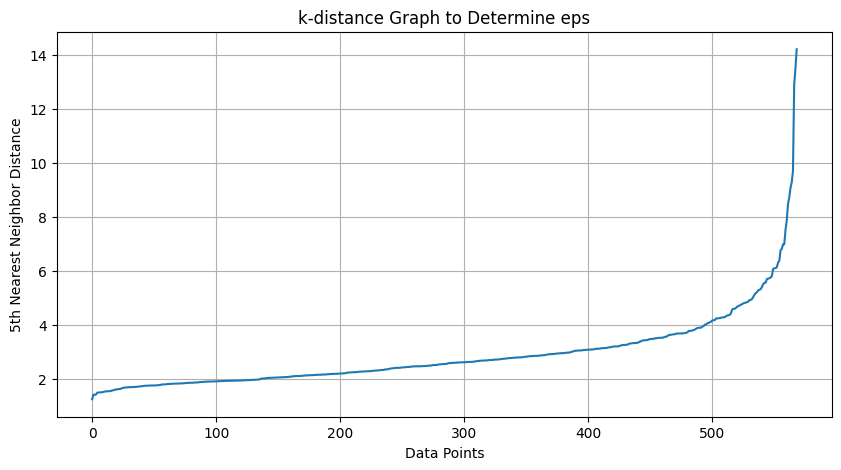

In [8]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit nearest neighbors
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Plot sorted distances
distance_desc = np.sort(distances[:, 4])
plt.figure(figsize=(10, 5))
plt.plot(distance_desc)
plt.title("k-distance Graph to Determine eps")
plt.xlabel("Data Points")
plt.ylabel("5th Nearest Neighbor Distance")
plt.grid(True)
plt.show()

### Observation:
- The k-distance graph shows an elbow around **`eps = 2`**.
- We'll use `eps = 2` and `min_samples = 5` (default) for DBSCAN.

Homogeneity Score: 0.221
Cluster Labels: [-1  0  1  2  3]
Cluster Distribution: [371  12 181   3   2]


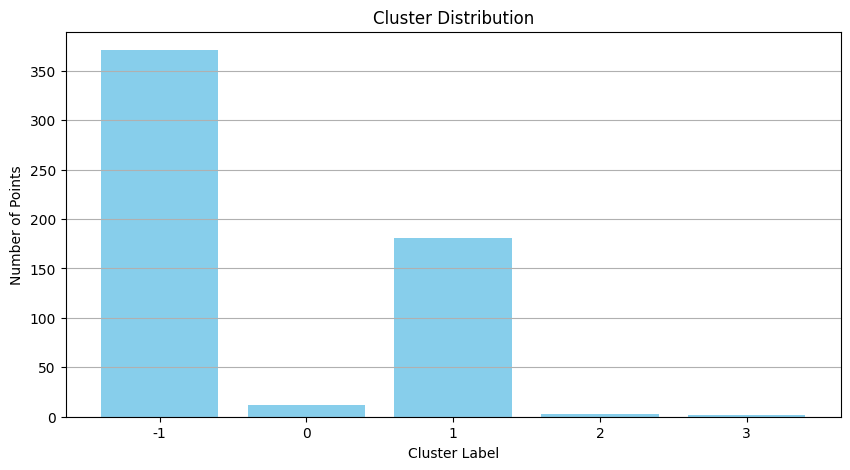

In [9]:
# Apply DBSCAN
dbscan = DBSCAN(eps=2, min_samples=5)
clusters = dbscan.fit_predict(X_scaled)

# Encode diagnosis column for homogeneity score
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Evaluate clustering
homogeneity = homogeneity_score(y_encoded, clusters)
unique_clusters = np.unique(clusters)
cluster_distribution = np.bincount(clusters + 1)  # Shift by 1 for -1 (noise)

print(f"Homogeneity Score: {homogeneity:.3f}")
print(f"Cluster Labels: {unique_clusters}")
print(f"Cluster Distribution: {cluster_distribution}")

# Plot cluster distribution
plt.figure(figsize=(10, 5))
plt.bar(range(len(cluster_distribution)), cluster_distribution, color='skyblue')
plt.title("Cluster Distribution")
plt.xlabel("Cluster Label")
plt.ylabel("Number of Points")
plt.xticks(range(len(cluster_distribution)), unique_clusters)
plt.grid(axis='y')
plt.show()

### Observations on DBSCAN:

- **Clusters Formed:** 5 clusters including noise.
  - Cluster -1 (noise): 371 points
  - Cluster 0: 12 points
  - Cluster 1: 181 points
  - Cluster 2: 3 points
  - Cluster 3: 2 points

- **Homogeneity Score:** 0.221
  - Indicates poor alignment between clusters and actual diagnosis labels.

### Conclusion:
- DBSCAN created many noise points and only a few valid clusters.
- Low homogeneity score suggests DBSCAN was not very effective for this high-dimensional dataset.